## 1. Get Data

In [1]:
import tushare as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings("ignore")

In [2]:
pro = ts.pro_api()

In [3]:
def get_index_daily(ts_code, start_date):
    '''
    To get specified index data and formalize it
    output: A dataframe corresponds to a data
    '''
    df = pro.index_daily(ts_code = ts_code, start_date = start_date, end_date = '')
    df['trade_date'] = pd.to_datetime(df['trade_date'].astype(str), format = '%Y-%m-%d')
    df.set_index('trade_date',inplace=True)
    return df.sort_index()

In [4]:
# 沪深300
df = get_index_daily(ts_code = '000300.SH', start_date = '20200601')

In [5]:
df.head()

,ts_code,close,open,high,low,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2020-06-01,000300.SH,3971.3402,3901.7263,3976.3151,3901.7263,3867.0232,104.3170,2.6976,136456652.0,2.084365e+08
2020-06-02,000300.SH,3983.5677,3969.9521,3991.7761,3958.9774,3971.3402,12.2275,0.3079,144303060.0,1.955633e+08
2020-06-03,000300.SH,3983.6477,4001.1708,4018.6759,3982.9299,3983.5677,0.0800,0.0020,136597483.0,2.008828e+08
2020-06-04,000300.SH,3982.1851,3998.1636,3999.8051,3968.5723,3983.6477,-1.4626,-0.0367,104277737.0,1.490579e+08
2020-06-05,000300.SH,4001.2509,3988.2239,4001.2509,3967.9260,3982.1851,19.0658,0.4788,102443942.0,1.543113e+08


<AxesSubplot:xlabel='trade_date'>

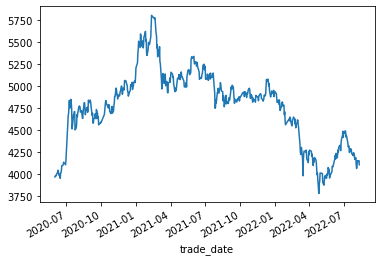

In [6]:
df.close.plot()

## 2. Preprocessing

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 535 entries, 2020-06-01 to 2022-08-10
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ts_code    535 non-null    object 
 1   close      535 non-null    float64
 2   open       535 non-null    float64
 3   high       535 non-null    float64
 4   low        535 non-null    float64
 5   pre_close  535 non-null    float64
 6   change     535 non-null    float64
 7   pct_chg    535 non-null    float64
 8   vol        535 non-null    float64
 9   amount     535 non-null    float64
dtypes: float64(9), object(1)
memory usage: 46.0+ KB


In [8]:
# df.dropna(inplace = True)

## 3. Feature Engineering

In [9]:
df_hs = df.copy()

In [10]:
for i in range(1, 8):
    df_hs['close-' + str(i) + 'd'] = df.close.shift(i)

df_hs.dropna(inplace = True)

In [11]:
# feature space
X_raw = df_hs[df_hs.columns[pd.Series(df_hs.columns).str.startswith('close-')]]

In [12]:
X_raw.head()

,close-1d,close-2d,close-3d,close-4d,close-5d,close-6d,close-7d
trade_date,,,,,,,
2020-06-10,4047.0293,4021.9549,4001.2509,3982.1851,3983.6477,3983.5677,3971.3402
2020-06-11,4039.7051,4047.0293,4021.9549,4001.2509,3982.1851,3983.6477,3983.5677
2020-06-12,3995.8846,4039.7051,4047.0293,4021.9549,4001.2509,3982.1851,3983.6477
2020-06-15,4003.0829,3995.8846,4039.7051,4047.0293,4021.9549,4001.2509,3982.1851
2020-06-16,3954.9883,4003.0829,3995.8846,4039.7051,4047.0293,4021.9549,4001.2509


In [13]:
df_hs['trend'] = np.where(df_hs['change'] > 0, 1, 0)

In [14]:
# target variable
y = df_hs.trend

In [15]:
print(X_raw.shape, y.shape)

(528, 7) (528,)


In [16]:
# Standardize data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [17]:
X = scaler.fit_transform(X_raw)

## 4. Modeling Training

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=1) #stratified sampling

In [20]:
# Logistic Regression
lg = LogisticRegression().fit(X_train, y_train)

In [21]:
# train f1 score
f1_score(y_train, lg.predict(X_train))

0.6365503080082136

In [22]:
# test f1 score
f1_score(y_test, lg.predict(X_test))

0.6463414634146342

In [23]:
# SVM
sv = SVC().fit(X_train, y_train)

In [24]:
# train f1 score
f1_score(y_train, sv.predict(X_train))

0.6476578411405295

In [25]:
# test f1 score
f1_score(y_test, sv.predict(X_test))

0.5838509316770187

### 4.1 Hyperparameter Tuning

#### Logistic Regression

In [26]:
from sklearn.model_selection import GridSearchCV

In [28]:
param_lg = {
    'tol':[0.01,0.001,0.0001],
    'penalty': ['none', 'l1', 'l2'], # improvement on out-of-sample prediction
    'C': [10, 1.0, 0.1, 0.01, 0.001], 
    'solver': ['lbfgs', 'liblinear']
}

In [29]:
lg_tuned = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = param_lg, 
                        scoring = 'f1')

In [30]:
lg_tuned.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [10, 1.0, 0.1, 0.01, 0.001],
                         'penalty': ['none', 'l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear'],
                         'tol': [0.01, 0.001, 0.0001]},
             scoring='f1')

In [31]:
print(lg_tuned.best_params_)

{'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.01}


#### Support Vector Machine Classifier

In [32]:
param_sv = {'kernel':('linear', 'rbf'), 'C':[1, 10, 0.1, 0.01, 0.001]}

In [33]:
sv_tuned = GridSearchCV(estimator = SVC(),
                        param_grid = param_sv, 
                        scoring = 'f1')

In [34]:
sv_tuned.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 0.1, 0.01, 0.001],
                         'kernel': ('linear', 'rbf')},
             scoring='f1')

In [35]:
print(sv_tuned.best_params_)

{'C': 0.1, 'kernel': 'rbf'}


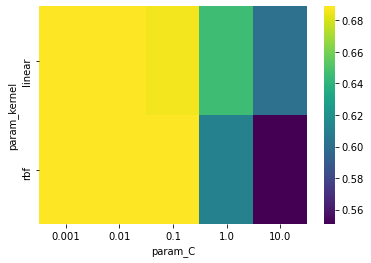

In [36]:
SV_models = pd.DataFrame(sv_tuned.cv_results_)
res = (SV_models.pivot(index='param_kernel', columns='param_C', values='mean_test_score'))
_ = sns.heatmap(res, cmap='viridis')

## 5. Model Evaluation

In [37]:
lg_clf = lg_tuned.best_estimator_

In [38]:
lg_clf.fit(X_train, y_train)

LogisticRegression(C=0.001, tol=0.01)

In [39]:
# f1 score of Logistic Regression

print("Logistic Regression: \n", 
      "In-sample f1 score: " + str(f1_score(y_train, lg_clf.predict(X_train))), 
      '\n', 
      "Out-of-sample f1 score: " + str(f1_score(y_test, lg_clf.predict(X_test))))

Logistic Regression: 
 In-sample f1 score: 0.6887417218543047 
 Out-of-sample f1 score: 0.693069306930693


In [40]:
sv_clf = sv_tuned.best_estimator_

In [41]:
sv_clf.fit(X_train, y_train)

SVC(C=0.1)

In [42]:
# f1 score of Support Vector Machine
print("Support Vector Machine:", "\n", 
        "In-sample accuracy: " + str(f1_score(y_train, sv_clf.predict(X_train))), 
      '\n', 
      "Out-of-sample accuracy: " + str(f1_score(y_test, sv_clf.predict(X_test))))


Support Vector Machine: 
 In-sample accuracy: 0.6887417218543047 
 Out-of-sample accuracy: 0.693069306930693


In [43]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([62, 70], dtype=int64))

In [44]:
lg_clf.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [45]:
sv_clf.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Limitation

Although the f1 score of both models did increase, the predicted output of these 2 models don't seem to be intelligent.